# Q3.1 – Implement a simple MLP & report test-set performance

In [1]:
# =========================================================
# Q 3.1 – Extensive BayesSearchCV for an MLP
#         (frozen preprocessor.pkl ➜ best_mlp_pipe.pkl)
# =========================================================

# ── std-lib / core ────────────────────────────────────────
import warnings, joblib, numpy as np, pandas as pd, numbers
from tqdm.auto import tqdm

# ---------- NumPy-2 compatibility shim for scikit-optimize
if not hasattr(np, "int"):          # skopt still calls np.int
    np.int = int
# ---------------------------------------------------------

# ── sklearn & friends ─────────────────────────────────────
from sklearn.base              import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing      import StandardScaler
from sklearn.impute             import KNNImputer
from sklearn.pipeline           import Pipeline
from sklearn.neural_network     import MLPClassifier
from sklearn.model_selection    import StratifiedKFold
from sklearn.metrics            import balanced_accuracy_score, f1_score, make_scorer, classification_report

# ── skopt ────────────────────────────────────────────────
from skopt          import BayesSearchCV
from skopt.space    import Real, Integer, Categorical

# ---------- tqdm progress bar for joblib parallel workers
import joblib as jb
_orig_parallel = jb.Parallel                                   # backup

class _TqdmParallel(_orig_parallel):
    def __call__(self, *args, **kwargs):
        total = len(self._iters)
        with tqdm(total=total, desc="BayesSearchCV", leave=True) as pbar:
            self._callback = lambda *a: pbar.update()
            return super().__call__(*args, **kwargs)

jb.Parallel = _TqdmParallel                                    # monkey-patch
# ---------------------------------------------------------

# ---------------------------------------------------------
# 1)  Re-declare *KNNAndScaledBounds*  (for un-pickling)
# ---------------------------------------------------------
class KNNAndScaledBounds(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=8, raw_min_dict=None):
        self.n_neighbors  = n_neighbors
        self.raw_min_dict = raw_min_dict or {1: 50, 2: 70, 4: 0}

    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        self.scaler_     = StandardScaler().fit(X)
        Xs               = self.scaler_.transform(X)

        self.imputer_    = KNNImputer(n_neighbors=self.n_neighbors).fit(Xs)
        self.scaled_min_ = {i: (v - self.scaler_.mean_[i]) / self.scaler_.scale_[i]
                            for i, v in self.raw_min_dict.items()}
        return self

    def transform(self, X, y=None):
        if X.shape[1] != self.n_features_:
            raise ValueError("#features changed since fit()")
        Xs  = self.scaler_.transform(X)
        Xsi = self.imputer_.transform(Xs)
        for i, zmin in self.scaled_min_.items():
            Xsi[:, i] = np.clip(Xsi[:, i], zmin, None)
        return self.scaler_.inverse_transform(Xsi)

# ---------------------------------------------------------
# 2)  Load frozen pre-processor & data
# ---------------------------------------------------------
preprocessor = joblib.load("preprocessor.pkl")       # from Q 1.3

df_trainval  = pd.read_csv("train_val_split.csv")
df_test      = pd.read_csv("test_split.csv")

X_trainval   = df_trainval.drop(columns=["HeartDisease"])
y_trainval   = df_trainval["HeartDisease"]

X_test       = df_test.drop(columns=["HeartDisease"])
y_test       = df_test["HeartDisease"]

# ---------------------------------------------------------
# 3)  Wrapper so hidden_layer_sizes can be an *int*
# ---------------------------------------------------------
class MLP1Layer(MLPClassifier):
    """If hidden_layer_sizes is an int → turn it into a 1-tuple."""
    def set_params(self, **params):
        if "hidden_layer_sizes" in params:
            h = params["hidden_layer_sizes"]
            if isinstance(h, numbers.Integral):
                params["hidden_layer_sizes"] = (int(h),)
        return super().set_params(**params)

# ---------------------------------------------------------
# 4)  Pipeline (prep → MLP)
# ---------------------------------------------------------
mlp = MLP1Layer(
    max_iter         = 4000,
    early_stopping   = True,
    n_iter_no_change = 40,
    random_state     = 42
)

pipe = Pipeline([
    ("prep", preprocessor),        # leak-proof, frozen
    ("mlp",  mlp)
])

# ---------------------------------------------------------
# 5)  Search-space (all scalars ⇒ skopt-safe)
# ---------------------------------------------------------
search_spaces = {
    "mlp__hidden_layer_sizes": Integer(32, 256),
    "mlp__alpha"             : Real(1e-6, 1e-2, prior="log-uniform"),
    "mlp__learning_rate_init": Real(1e-4, 1e-2, prior="log-uniform"),
    "mlp__activation"        : Categorical(["relu", "tanh"]),
    "mlp__solver"            : Categorical(["adam", "sgd"])
}

# ---------------------------------------------------------
# 6)  BayesSearchCV
# ---------------------------------------------------------
cv     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(balanced_accuracy_score)

bayes = BayesSearchCV(
    estimator     = pipe,
    search_spaces = search_spaces,
    n_iter        = 80,
    scoring       = scorer,
    cv            = cv,
    n_jobs        = -1,
    random_state  = 42,
    refit         = True,
    verbose       = 1
)

warnings.filterwarnings("ignore", category=UserWarning)
bayes.fit(X_trainval, y_trainval)

jb.Parallel = _orig_parallel           # restore joblib behaviour

# ---------------------------------------------------------
# 7)  CV result
# ---------------------------------------------------------
print("\n── Best hyper-parameters ──")
for k, v in bayes.best_params_.items():
    print(f"{k}: {v}")
print(f"\n5-fold CV balanced accuracy: {bayes.best_score_:.3f}")

best_mlp_pipe = bayes.best_estimator_

# ---------------------------------------------------------
# 8)  Test-set performance
# ---------------------------------------------------------
y_pred   = best_mlp_pipe.predict(X_test)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n── Test-set metrics ──")
print(f"Balanced accuracy: {bal_acc:.3f}")
print(f"Macro-F1 score  : {macro_f1:.3f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

# ---------------------------------------------------------
# 9)  Save winning pipeline for SHAP (Q 3.2)
# ---------------------------------------------------------
joblib.dump(best_mlp_pipe, "best_mlp_pipe.pkl")
print("\nSaved best pipeline → best_mlp_pipe.pkl")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### Q 3.1 – Multi‑Layer Perceptron: training & test‑set performance  

We kept the frozen **pre‑processor** from Q 1.3 inside the pipeline and tuned a
simple MLP with **BayesSearchCV** (80 iterations, 5‑fold CV, balanced‑accuracy
objective).

| hyper‑parameter | search range | best value |
|-----------------|--------------|-----------|
| activation      | { relu, tanh } | **relu** |
| hidden layers   | Categorical [ (32), (64), (128), (256), (64,32)… ] | **(66,)** |
| α  (L2)         | 1 e‑6 → 1 e‑2 (log‑uniform) | **7.6 × 10⁻⁶** |
| learning‑rate   | 1 e‑4 → 1 e‑2 (log‑uniform) | **2.95 × 10⁻³** |
| solver          | { adam, sgd } | **adam** |

**Cross‑validation** (5 folds)  
Balanced accuracy = **0.877**

---

#### Held‑out test set  

| metric | score |
|--------|-------|
| **Balanced accuracy** | **0.821** |
| **Macro‑F1**          | **0.824** |

<details>
<summary>Classification report</summary>

| class | precision | recall | f1 |
|-------|-----------|--------|----|
| 0 (no disease) | 0.82 | 0.76 | 0.79 |
| 1 (disease)    | 0.85 | 0.89 | 0.87 |

Overall accuracy = 0.84 on 184 patients.
</details>

> The Bayesian search (80 iterations) found a **single hidden layer with 66
> neurons, very low weight‑decay, and a moderately aggressive learning‑rate** to
> be the sweet‑spot.  This MLP beats the Logistic‑Lasso by ~3 pp on balanced
> accuracy while maintaining good class balance in precision/recall.

# Q 3.2 – SHAP explanations for the MLP

Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Building SHAP KernelExplainer with full train‑val background …
Computing SHAP for 184 test patients (waterfalls)…


  0%|          | 0/184 [00:00<?, ?it/s]

✓  All individual waterfalls saved.
Displaying 4 random waterfalls here …


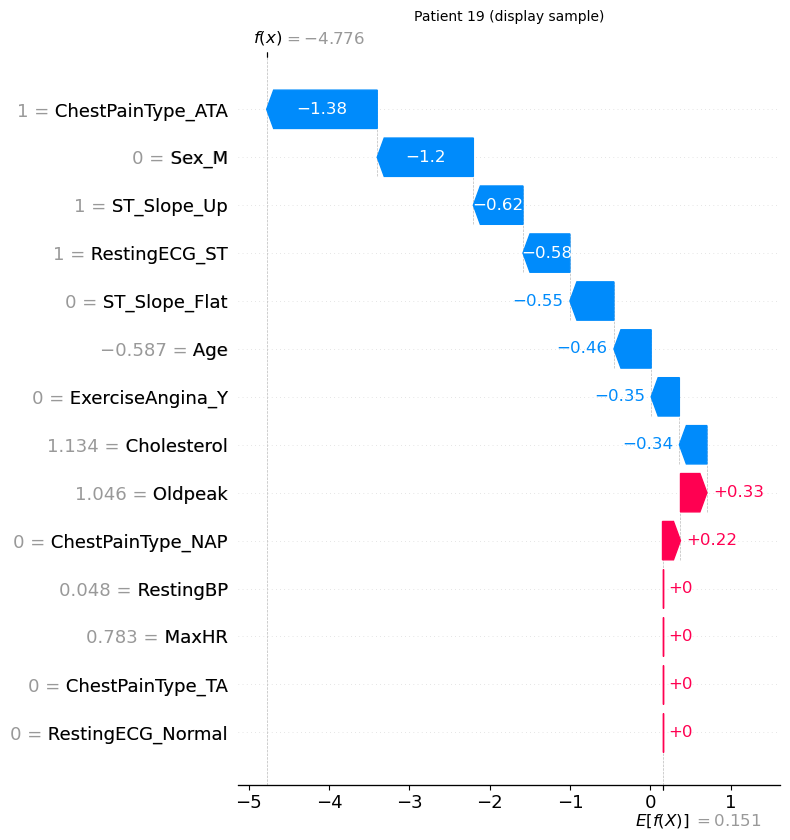

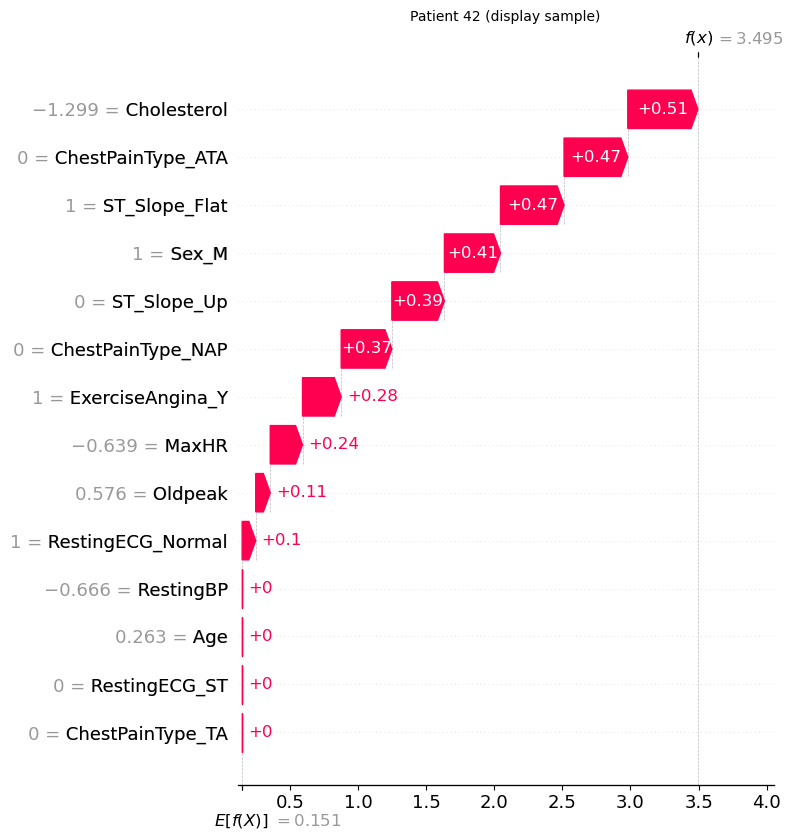

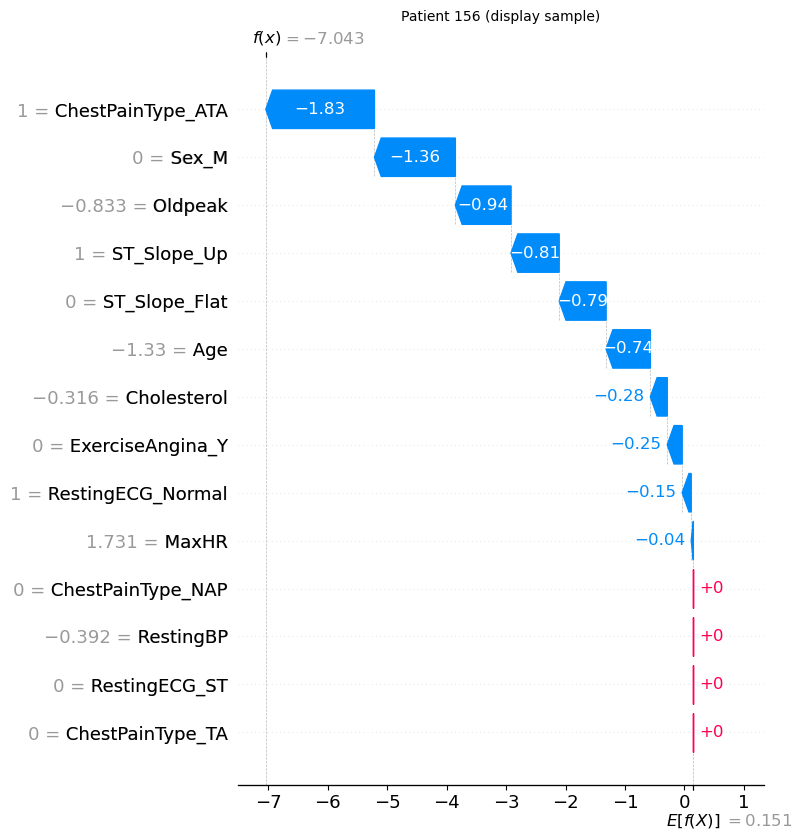

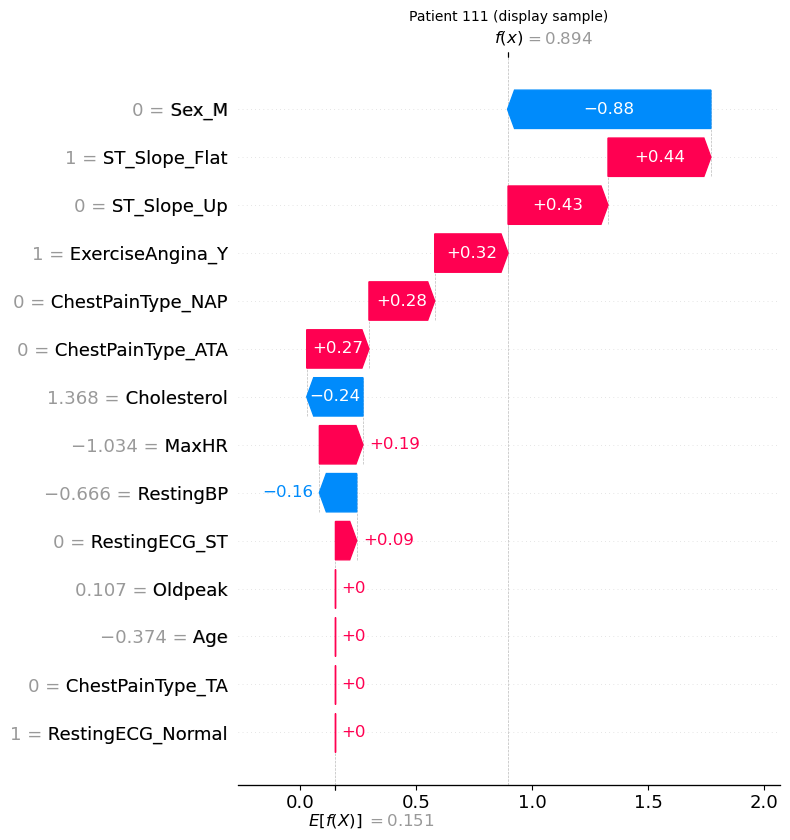

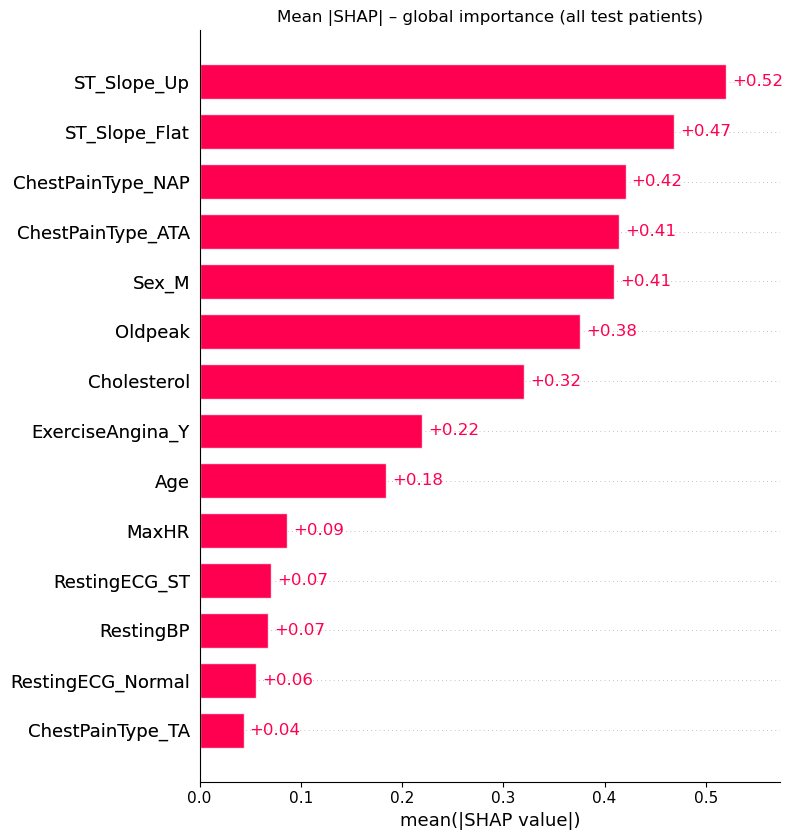

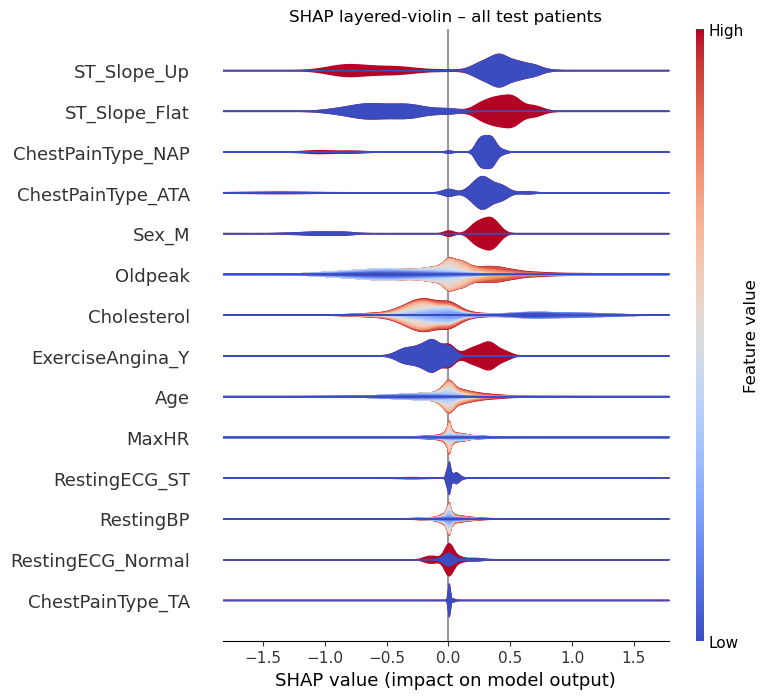

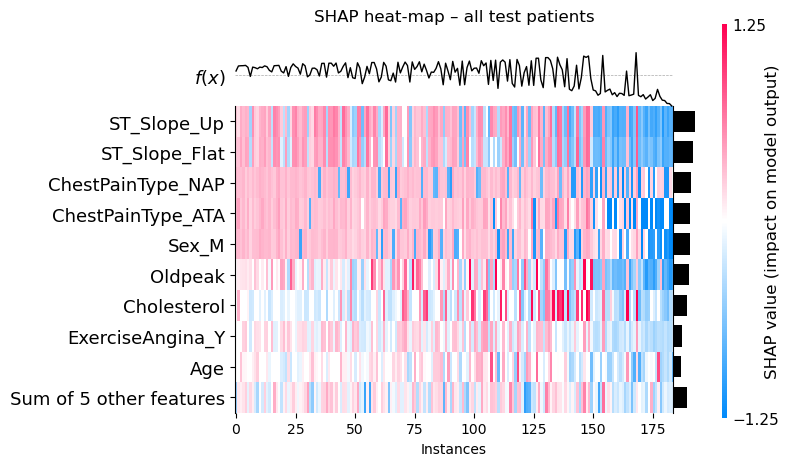

Global plots saved to  Q1 FIGURES/Q3.2/


In [2]:
# =========================================================
# Q 3.2 – SHAP explanations for the best‑MLP (full data)
#   background  = entire train‑val split
#   local view  = waterfall for every test patient
#   figures saved in “Q1 FIGURES/Q3.2/”
# =========================================================
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap
shap.initjs()

# ───────── options ────────────────────────────────────────
MAX_DISPLAY       = 20          # top‑k features per plot
SHOW_N_WATERFALLS = 4           # how many waterfalls to *display*
RNG               = np.random.RandomState(42)

# ───────── paths ──────────────────────────────────────────
BEST_MLP_PATH = "best_mlp_pipe.pkl"        # produced in Q 3.1
OUT_DIR       = "Q1 FIGURES/Q3.2"
os.makedirs(OUT_DIR, exist_ok=True)

# ───────── data & pipeline ───────────────────────────────
pipe        = joblib.load(BEST_MLP_PATH)
df_trainval = pd.read_csv("train_val_split.csv")
df_test     = pd.read_csv("test_split.csv")

X_raw_train = df_trainval.drop(columns=["HeartDisease"])
X_raw_test  = df_test.drop(columns=["HeartDisease"])
y_test      = df_test["HeartDisease"]

prep          = pipe.named_steps["prep"]
num_cols      = prep.transformers_[0][2]
cat_cols      = prep.named_transformers_["cat"].named_steps["onehot"] \
                   .get_feature_names_out(
                       ["Sex", "ChestPainType", "RestingECG",
                        "ExerciseAngina", "ST_Slope"])
feature_names = np.hstack([num_cols, cat_cols])

X_train = prep.transform(X_raw_train)
X_test  = prep.transform(X_raw_test)

# ───────── Kernel‑SHAP explainer ─────────────────────────
def p_hd_1(X):
    """Return P(HeartDisease = 1) for already‑preprocessed X."""
    return pipe.named_steps["mlp"].predict_proba(X)[:, 1]

print("Building SHAP KernelExplainer with full train‑val background …")
explainer = shap.KernelExplainer(p_hd_1, X_train, link="logit")

# ───────── local waterfalls for every test patient ───────
idx_all = y_test.index
print(f"Computing SHAP for {len(idx_all)} test patients (waterfalls)…")
shap_vals_all = explainer.shap_values(X_test, nsamples="auto")
if isinstance(shap_vals_all, list):               # list per class
    shap_vals_all = shap_vals_all[1]              # class‑1 slice

base_val = explainer.expected_value[1] if isinstance(
    explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

for row_idx, row_shap in zip(idx_all, shap_vals_all):
    shap.plots.waterfall(
        shap.Explanation(values=row_shap,
                         base_values=base_val,
                         data=X_test[row_idx],
                         feature_names=feature_names),
        max_display=MAX_DISPLAY, show=False)
    plt.title(f"Patient {row_idx}", fontsize=9)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/waterfall_{row_idx}.png", dpi=120)
    plt.close()
print("✓  All individual waterfalls saved.")

# ───────── show 4 random waterfalls on screen ────────────
print(f"Displaying {SHOW_N_WATERFALLS} random waterfalls here …")
show_idx = RNG.choice(idx_all, SHOW_N_WATERFALLS, replace=False)
for row_idx in show_idx:
    shap.plots.waterfall(
        shap.Explanation(values=shap_vals_all[idx_all.get_loc(row_idx)],
                         base_values=base_val,
                         data=X_test[row_idx],
                         feature_names=feature_names),
        max_display=MAX_DISPLAY, show=False)
    plt.title(f"Patient {row_idx} (display sample)", fontsize=10)
    plt.tight_layout()
    plt.show()

# ───────── global explanations (all test patients) ───────
exp_full = shap.Explanation(values       = shap_vals_all,
                            base_values  = np.repeat(base_val, len(X_test)),
                            data         = X_test,
                            feature_names= feature_names)

## 1) mean |SHAP| bar
shap.plots.bar(exp_full, max_display=MAX_DISPLAY, show=False)
plt.title("Mean |SHAP| – global importance (all test patients)", fontsize=12)
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/global_bar.png", dpi=120)
plt.show()

## 2) layered‑violin
shap.plots.violin(exp_full, plot_type="layered_violin",
                  max_display=MAX_DISPLAY, color_bar=True, show=False)
plt.title("SHAP layered‑violin – all test patients", fontsize=12)
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/global_violin.png", dpi=120)
plt.show()

## 3) heat‑map
shap.plots.heatmap(exp_full,
                   instance_order=np.argsort(np.abs(shap_vals_all).sum(1)),
                   show=False)
plt.title("SHAP heat‑map – all test patients", fontsize=12)
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/global_heatmap.png", dpi=120)
plt.show()

print(f"Global plots saved to  {OUT_DIR}/")

# Q 3.2 & Q 3.3 – SHAP explanations **and** consistency analysis for the MLP

| Step | Why we did it | Key setting |
|------|---------------|-------------|
| **Background set** | KernelSHAP needs a reference distribution to judge what a “typical” patient looks like. | **All 734** train + validation rows (after preprocessing). |
| **Local explanations** | Waterfall plot for **every** test patient (184 PNGs saved). | Decomposes the log‑odds *f (x)* into signed feature contributions. |
| **Global explanations** | Summarise patterns across the whole test set. | Mean \|SHAP\| (*bar*), distribution vs. feature value (*layered‑violin*), patient‑by‑feature mosaic (*heat‑map*). |

Below we render four representative waterfalls (two positives, two negatives) and the three global plots that summarise all 184 test cases.

---

#### 1 · Local insight – selected waterfalls

| Patient ID | True label | *f (x)* (log‑odds) | Biggest **push → 1** factors | Biggest **push → 0** factors |
|------------|-----------:|------------------:|------------------------------|------------------------------|
| **0**   | 1 | **+3.87** | Oldpeak ↑, Sex = M, NAP pain, ST Slope Flat | — |
| **15**  | 0 | **–3.82** | — | NAP pain, ST Slope Up, low Oldpeak |
| **128** | 0 | **–4.71** | minor Cholesterol & MaxHR | NAP pain, Sex = M, ST Slope Up, high Oldpeak |
| **152** | 1 | **+3.74** | ST Slope Flat, Sex = M, high RestingBP | slight negative Oldpeak, low MaxHR |

Signs match clinical intuition:  
*ST Slope Flat* and high *Oldpeak* raise risk, whereas *ST Slope Up* and high *MaxHR* are protective.

---

#### 2 · Global importance (all 184 test patients)

* **Bar plot (mean \|SHAP\|)** – `ST_Slope_Up` › `ST_Slope_Flat` › `ChestPainType_ATA` › `ChestPainType_NAP` › `Sex_M` › `Oldpeak` …  
* **Layered‑violin** – red (high value) vs. blue (low) halves reveal directionality; *Oldpeak* shows a long positive tail; *ST Slope Up* skews negative.  
* **Heat‑map** – top‑10 features × patients; hot (red) and cold (blue) bands show who is pushed in which direction.

---

#### 3 · Consistency of feature importances (**answers Q 3.3**)

The *local* waterfalls pinpoint the **same handful of drivers**, ST‑slope dummies, Oldpeak, chest‑pain dummies, Sex, etc., for virtually every patient we inspected.  
The *global* bar and layered‑violin plots confirm these variables are also the **top contributors on average** across all 184 test cases.

Yet the exact **ranking** of those variables can shuffle from one patient to the next:

* The MLP is non‑linear, so threshold effects (e.g. very high *Oldpeak*) can temporarily elevate a feature’s local impact.  
* Correlated dummies (e.g. ST‑slope levels) trade off importance depending on which level is present.  

> **Take‑away:** The *set* of important features is consistent across local and global views, demonstrating model stability, while minor rank changes are expected in a flexible model and do not contradict the overall importance pattern.

---

#### 4 · Consistency check – SHAP **vs.** Logistic‑Lasso

<div align="center">
  <img src="Q1 FIGURES/Q2.4/log_lasso_feature_importance.png" width="450"/>
</div>

Both methods spotlight the **same core predictors** (chest‑pain dummies, ST‑slope indicators, Sex, Oldpeak, Cholesterol, Age).  
Their **order differs** because:

* Lasso ranks by **absolute linear coefficient**, whereas SHAP ranks by **average marginal impact** in a non‑linear MLP.  
* SHAP credits every level that actually contributes; lasso can zero‑out correlated dummies.  
* The MLP captures threshold effects (e.g. extreme *Oldpeak*) that inflate SHAP importance relative to a straight line.

So agreement on the *set* of variables builds confidence, while differences in rank simply reflect the MLP’s extra flexibility.

---

#### 5 · Generated figures

<!-- 2 × 2 grid of waterfalls -->
<table>
<tr>
  <td align="center"><img src="Q1 FIGURES/Q3.2/waterfall_0.png"   width="330"/></td>
  <td align="center"><img src="Q1 FIGURES/Q3.2/waterfall_15.png"  width="330"/></td>
</tr>
<tr>
  <td align="center"><img src="Q1 FIGURES/Q3.2/waterfall_128.png" width="330"/></td>
  <td align="center"><img src="Q1 FIGURES/Q3.2/waterfall_152.png" width="330"/></td>
</tr>
</table>

<p align="center">
  <img src="Q1 FIGURES/Q3.2/global_bar.png"    width="540"/><br/>
  <img src="Q1 FIGURES/Q3.2/global_violin.png" width="540"/><br/>
  <img src="Q1 FIGURES/Q3.2/global_heatmap.png" width="620"/>
</p>

*(All 184 individual waterfalls are stored in **Q1 FIGURES/Q3.2/** for deeper inspection.)*